In [1]:
import os, sys, glob, pdb, random, time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from PIL import Image
from importlib import reload
from skimage import measure

sys.path.append('../')
import models.BuildCNN as BuildCNN
import models.VeinGrower as VeinGrower
from utils.GetLowestGPU import GetLowestGPU

if 'device' not in locals():
    device = torch.device(GetLowestGPU(verbose=2))

---------------------------
 GPU | Memory-usage    
---------------------------
  0  | 02915MiB / 40537MiB
  1  | 06238MiB / 40537MiB
  2  | 00003MiB / 40537MiB
  3  | 00003MiB / 40537MiB
  4  | 00003MiB / 40537MiB
  5  | 00003MiB / 40537MiB
  6  | 00003MiB / 40537MiB
  7  | 02694MiB / 40537MiB
---------------------------
 Device set to cuda:2
---------------------------


# Initialize grower

In [2]:
# options
window_size = 128
weights_path = f'../weights/vein_grower_{window_size}_best_val_model.save'
layers = layers = [3, 32, 32, 32, 32, 64, 128]
output_shape = [2, 3, 3]
output_activation = torch.nn.Softmax2d()

# load CNN model
print('loading cnn model...')
reload(BuildCNN)
model = BuildCNN.CNN(
    window_size=window_size, 
    layers=layers,
    output_shape=output_shape,
    output_activation=output_activation).to(device)
weights = torch.load(weights_path, map_location=device)
model.load_state_dict(weights)
model.eval()

# initialize vein grower
print('initializing vein grower...')
reload(VeinGrower)
grower = VeinGrower.VeinGrower(
    window_size=window_size, 
    model=model,
    device=device, 
    verbose=True)

loading cnn model...
initializing vein grower...


# Grower inference

Loading C_1_10_10_bot.jpeg...
Iteration 337 | Samples = 0             
Computing optimal threshold...
Post processing...
Iteration completed in 73.14 seconds
Plotting overlay...


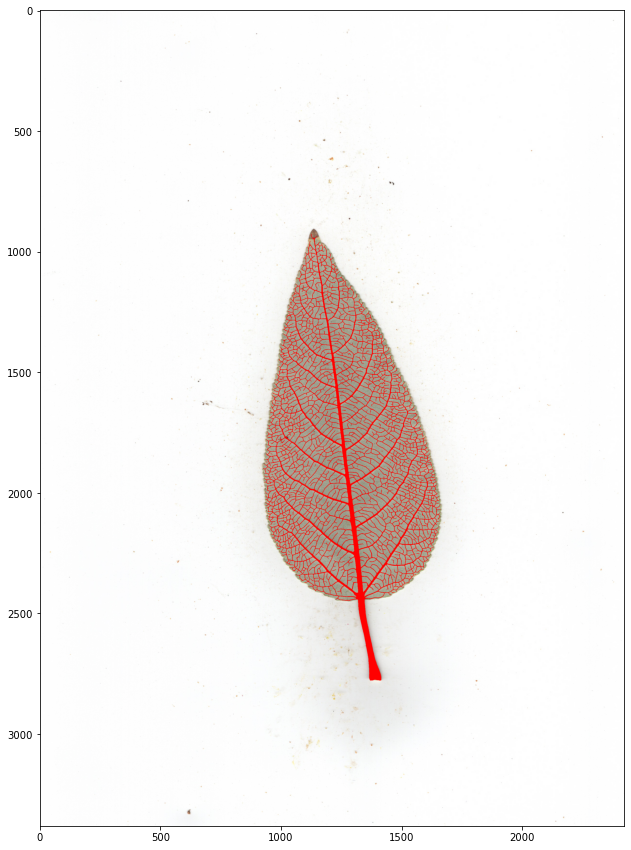


Loading C_1_10_12_bot.jpeg...
Iteration 496 | Samples = 0             
Computing optimal threshold...
Post processing...
Iteration completed in 79.46 seconds
Plotting overlay...


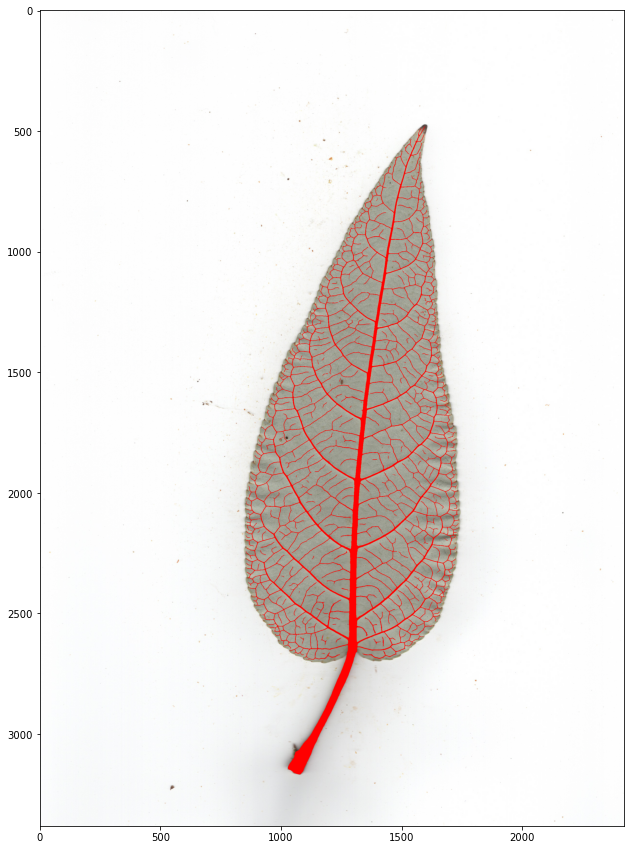


Loading C_1_10_13_bot.jpeg...
Iteration 272 | Samples = 0             
Computing optimal threshold...
Post processing...
Iteration completed in 49.09 seconds
Plotting overlay...


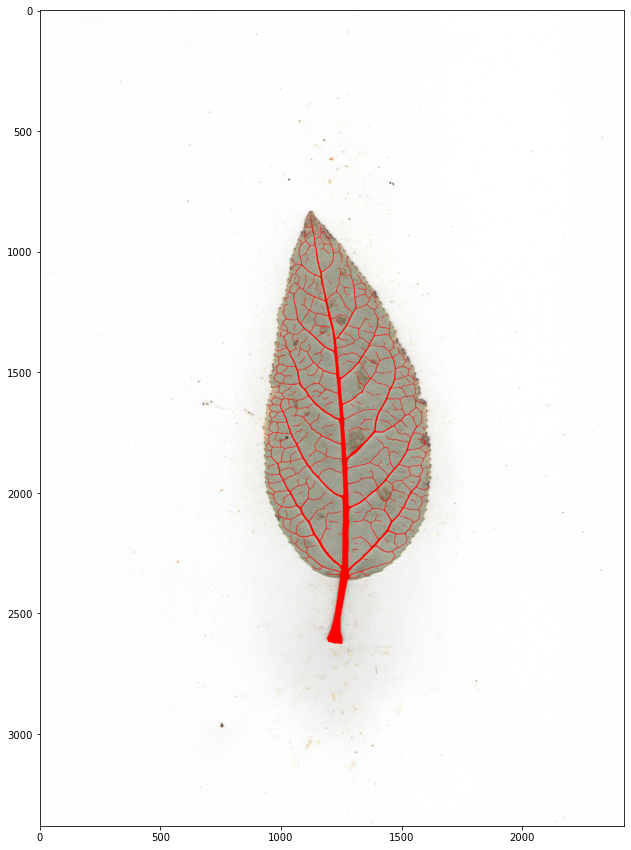


Loading C_1_10_14_bot.jpeg...
Iteration 454 | Samples = 0             
Computing optimal threshold...
Post processing...
Iteration completed in 63.64 seconds
Plotting overlay...


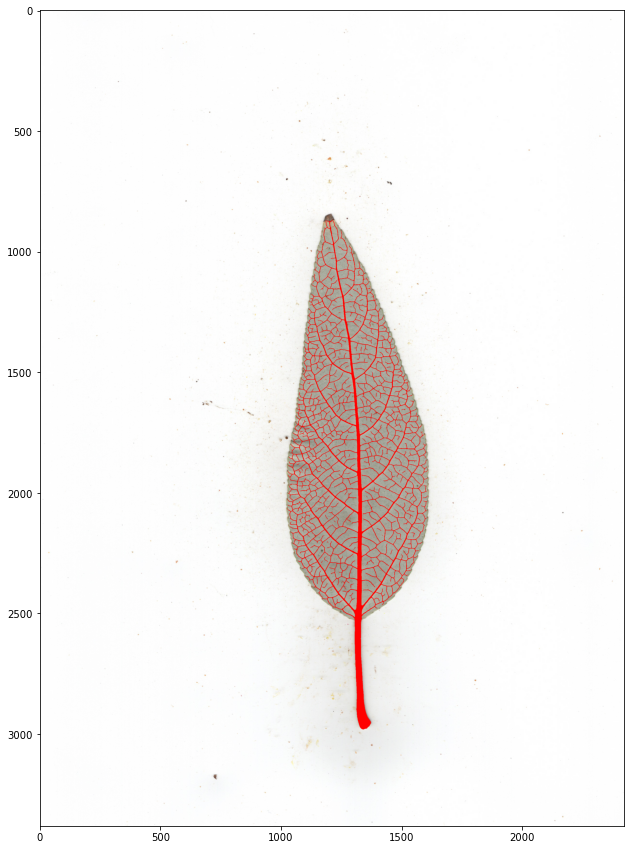


Loading C_1_10_15_bot.jpeg...
Iteration 350 | Samples = 0             
Computing optimal threshold...
Post processing...
Iteration completed in 56.35 seconds
Plotting overlay...


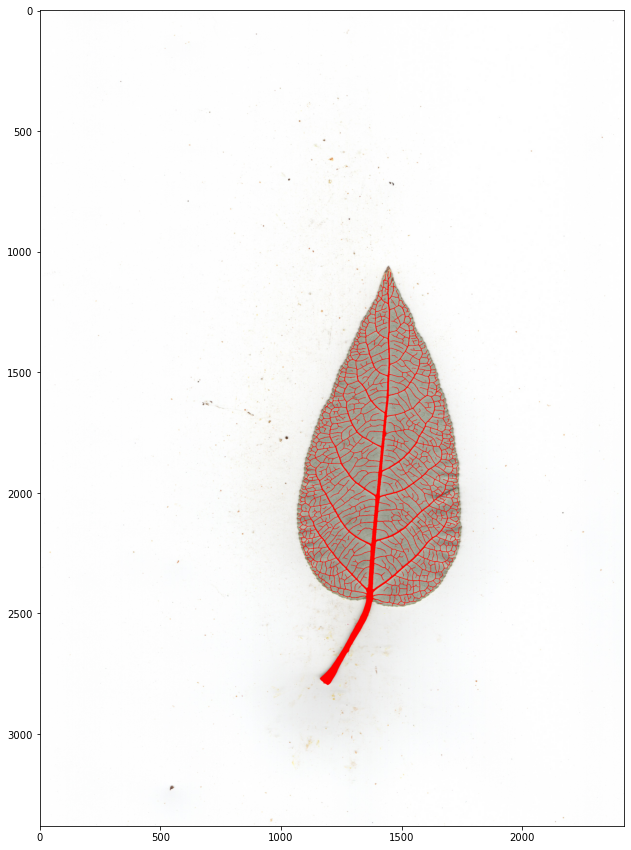


Loading C_1_10_16_bot.jpeg...
Iteration 377 | Samples = 0             
Computing optimal threshold...
Post processing...
Iteration completed in 83.19 seconds
Plotting overlay...


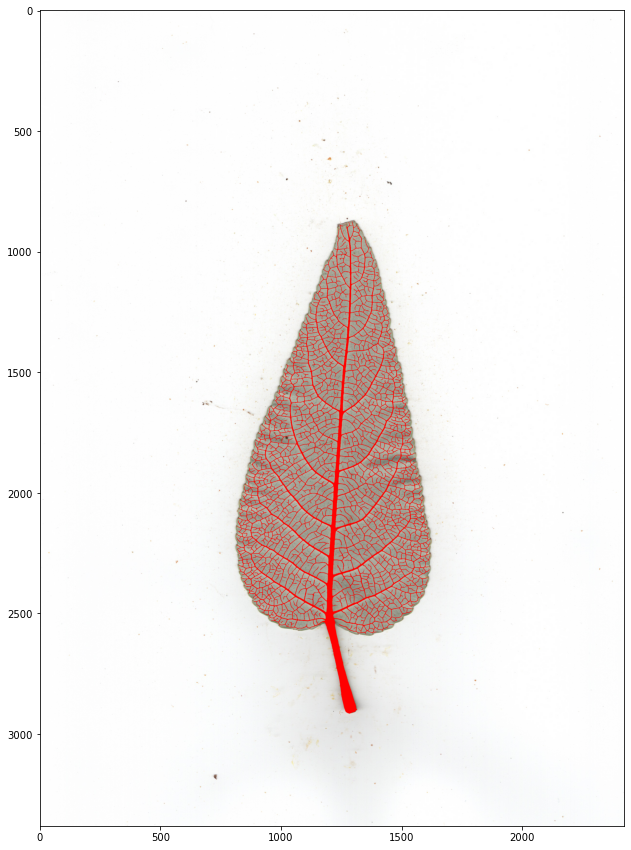


Loading C_1_10_17_bot.jpeg...
Iteration 315 | Samples = 0             
Computing optimal threshold...
Post processing...
Iteration completed in 48.91 seconds
Plotting overlay...


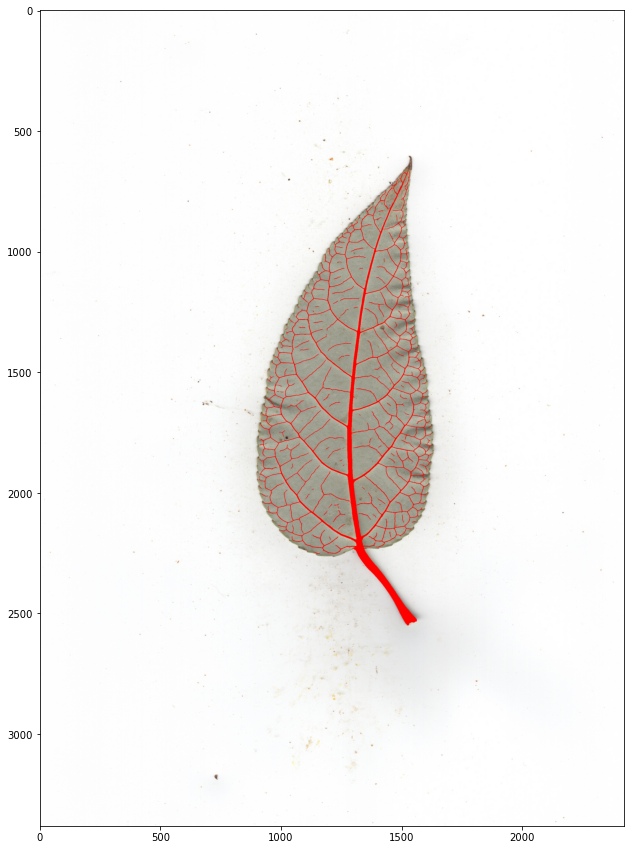


Loading C_1_10_18_bot.jpeg...
Iteration 444 | Samples = 0             
Computing optimal threshold...
Post processing...
Iteration completed in 79.55 seconds
Plotting overlay...


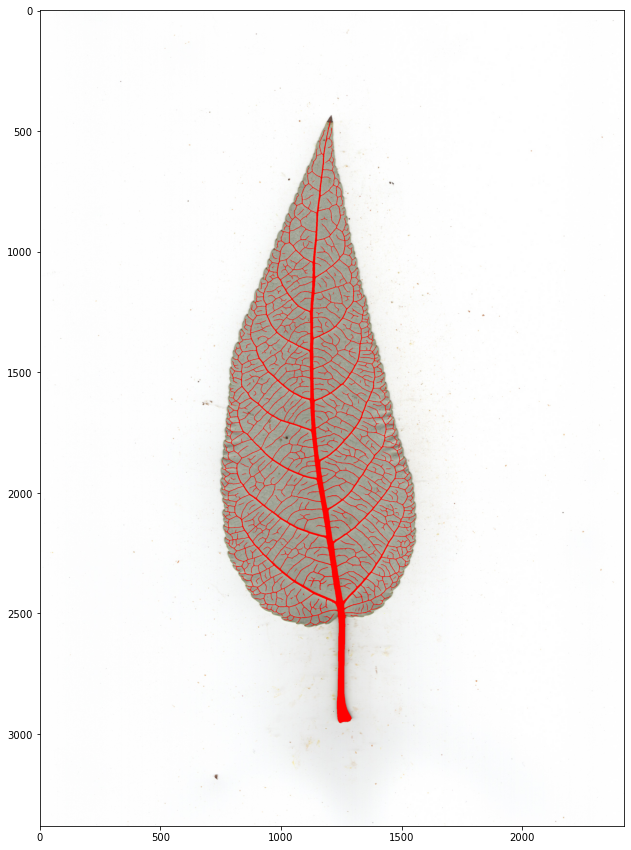


Loading C_1_10_19_bot.jpeg...
Iteration 662 | Samples = 0              
Computing optimal threshold...
Post processing...
Iteration completed in 113.35 seconds
Plotting overlay...


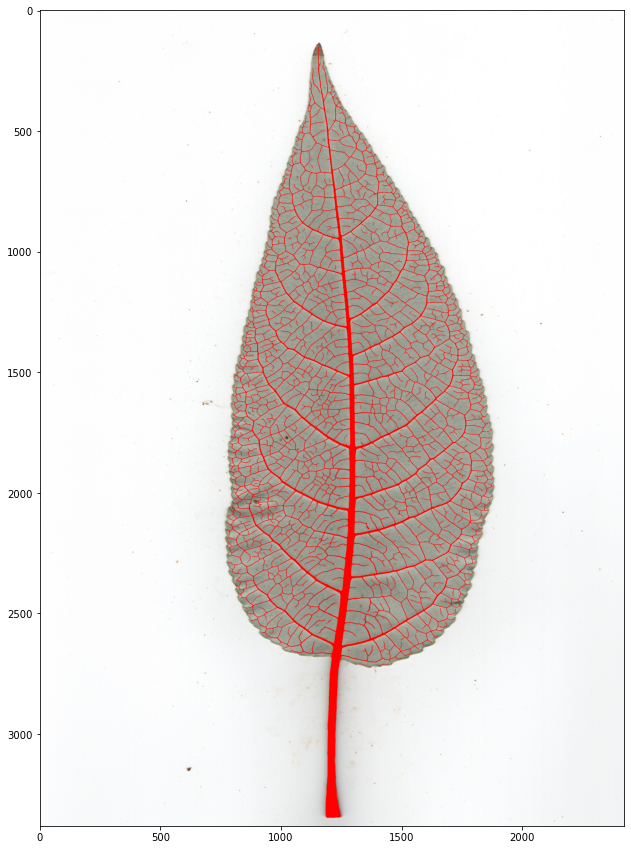


Loading C_1_10_1_bot.jpeg...
Iteration 292 | Samples = 0             
Computing optimal threshold...
Post processing...
Iteration completed in 81.69 seconds
Plotting overlay...


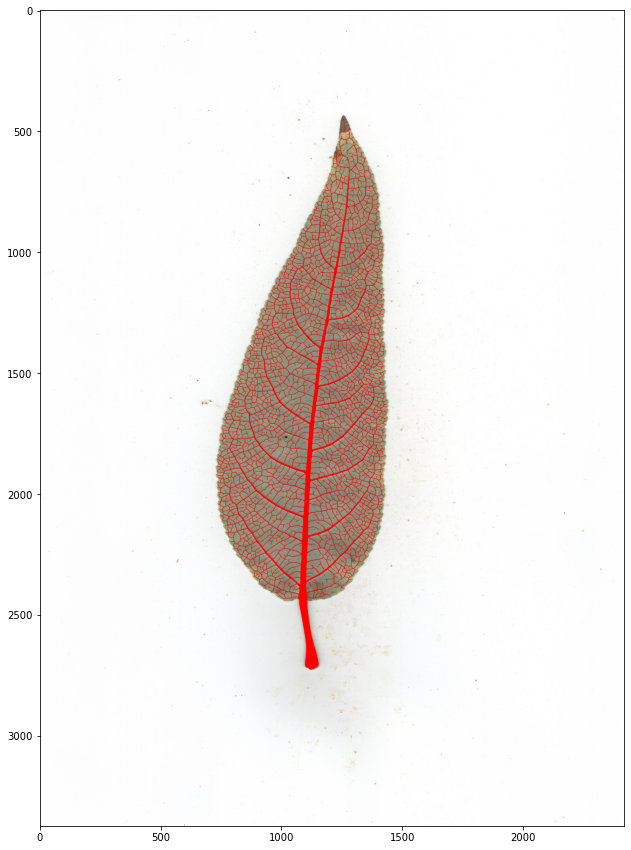

In [3]:
# options
image_path = '../data/images/'
roi_path = '../data/leaf_preds/'
pred_path = '../data/vein_preds/'
prob_path = '../data/vein_probs/'
image_extension = 'jpeg'
roi_extension = 'png'
pred_extension = 'png'
prob_extension = 'png'
n_locs = 10000 # number of seed pixels
batch_size = 1024
threshold = None
post_process = True
max_number = 10 # number of images to segment, set to None for all images
verbose = True
save = False
show = True
fig_size = 15

# get image paths
image_names = [os.path.basename(f) for f in glob.glob(image_path+'*'+image_extension) if '_bot' in f]
image_names.sort()

# loop over all leaf images
for image_idx, image_name in enumerate(image_names):
    
    # don't exceed maximum
    if max_number is not None:
        if image_idx >= max_number:
            break
            
    # load image
    if verbose:
        print(f'Loading {image_name}...')
    image = np.array(Image.open(image_path + image_name), dtype=np.float32)/255
    if roi_path is not None:
        roi = np.array(Image.open(
            roi_path + image_name.replace(image_extension, roi_extension)), dtype=np.float32)/255
        roi = roi[:,:,0] > 0.5
    else:
        roi = None
    
    # segment the venation
    t0 = time.time()
    prob, mask = grower.grow(
        image=image, 
        roi=roi, 
        start_locs=None, 
        n_locs=n_locs, 
        batch_size=batch_size, 
        threshold=threshold,
        post_process=post_process)
    t1 = time.time()
    if verbose:
        print('Iteration completed in {0:1.2f} seconds'.format(t1-t0))

    # remove padding
    image = image[
        int(window_size/2):-int(window_size/2), 
        int(window_size/2):-int(window_size/2)]
    mask = mask[
        int(window_size/2):-int(window_size/2), 
        int(window_size/2):-int(window_size/2)]
    prob = prob[
        int(window_size/2):-int(window_size/2), 
        int(window_size/2):-int(window_size/2)]

    # save mask
    if save:
        if verbose: 
            print('Saving mask...')
        save_mask = np.concatenate([mask[:,:,None], mask[:,:,None], mask[:,:,None]], axis=-1)
        pil_mask = Image.fromarray(np.uint8(255*save_mask))
        name = pred_path + image_name.replace(image_extension, pred_extension)
        pil_mask.save(name, quality=100, subsampling=0)

    # save prob
    if save:
        if verbose: 
            print('Saving prob...')
        save_prob = np.concatenate([prob[:,:,None], prob[:,:,None], prob[:,:,None]], axis=-1)
        pil_prob = Image.fromarray(np.uint8(255*save_prob))
        name = prob_path + image_name.replace(image_extension, prob_extension)
        pil_prob.save(name, quality=100, subsampling=0)

    # plot overlay
    if show:
        if verbose: 
            print('Plotting overlay...')
        image[mask] = [1, 0, 0]
        fig = plt.figure(figsize=(image.shape[1]/image.shape[0]*fig_size, fig_size))
        plt.imshow(image)
        plt.show()
        
    if verbose: 
        print()